# ConvFormer Visualization and Metrics

This notebook loads the trained ProbFormer model and visualizes predictions on samples from the GreenEarthNet dataset.

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path

# Add parent directory to path if needed, though usually current dir is in path
sys.path.append(os.getcwd())

from greenearthnet_dataset import GreenEarthNetGenerator
from convformer import ConvFormer

2025-12-01 13:31:37.303235: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 13:31:37.312778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764595897.326753   90937 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764595897.332006   90937 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764595897.342200   90937 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## 1. Load Data
We load 5 samples from the dataset.

In [2]:
DATA_DIR = '/home/me/workspace/probformer/data/greenearthnet/traint_test'
NUM_SAMPLES = 5

generator = GreenEarthNetGenerator(DATA_DIR)
dataset = generator.get_dataset()

# Take 5 samples
samples = []
for x, y in dataset.take(NUM_SAMPLES):
    samples.append((x, y))
    
print(f"Loaded {len(samples)} samples.")

I0000 00:00:1764595910.541436   90937 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4143 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Loaded 5 samples.


2025-12-01 13:31:51.654540: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 2. Load Model
Load the trained model weights.

In [3]:
CHECKPOINT_PATH = '/home/me/workspace/convformer/checkpoints/convformer_best.weights.h5'
QUANTILES = [0.1, 0.5, 0.9]

model = ConvFormer(forecast_horizon=20, quantiles=QUANTILES)

# Build the model by passing a dummy input or calling build
# The model expects a dict of inputs. We can use one sample to build it.
dummy_x = samples[0][0]
# Add batch dimension
dummy_x_batch = {k: tf.expand_dims(v, 0) for k, v in dummy_x.items()}

model(dummy_x_batch)

print(f"Loading weights from {CHECKPOINT_PATH}...")
try:
    model.load_weights(CHECKPOINT_PATH)
    print("Weights loaded successfully.")
except Exception as e:
    print(f"Error loading weights: {e}")
    print("Make sure you have trained the model and the checkpoint exists.")

I0000 00:00:1764595984.832424   90937 cuda_dnn.cc:529] Loaded cuDNN version 91501
2025-12-01 13:33:06.138911: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Loading weights from /home/me/workspace/convformer/checkpoints/convformer_best.weights.h5...
Weights loaded successfully.


## 3. Visualize Predictions
We plot the Ground Truth vs Predicted NDVI for selected time steps.

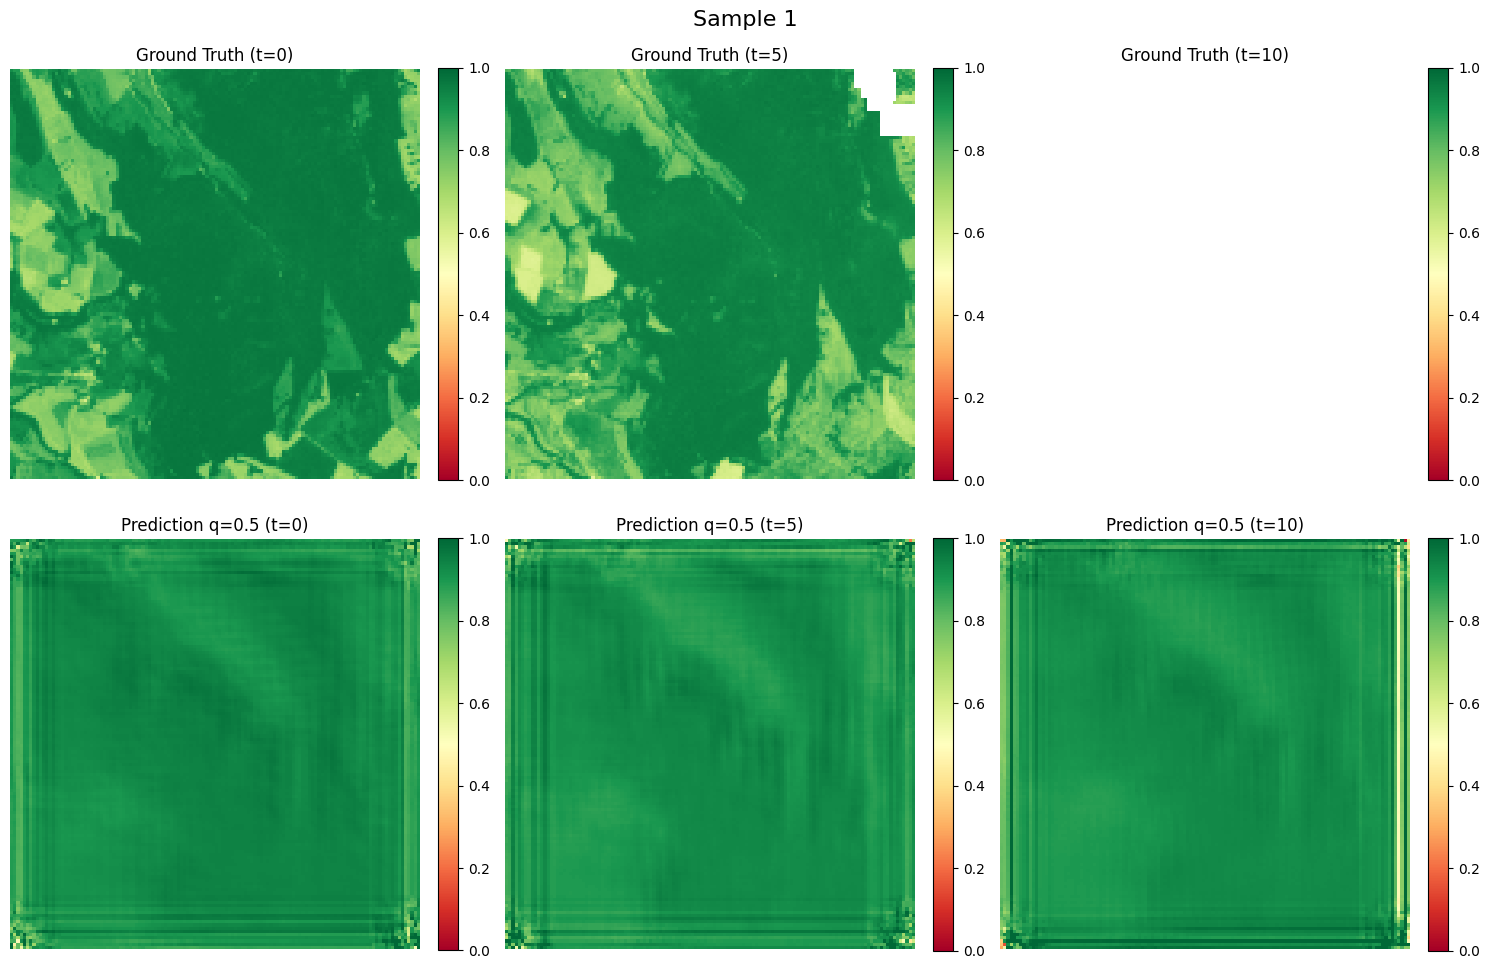

Sample 1 Metrics:
  MSE: 0.0065
  MAE: 0.0558


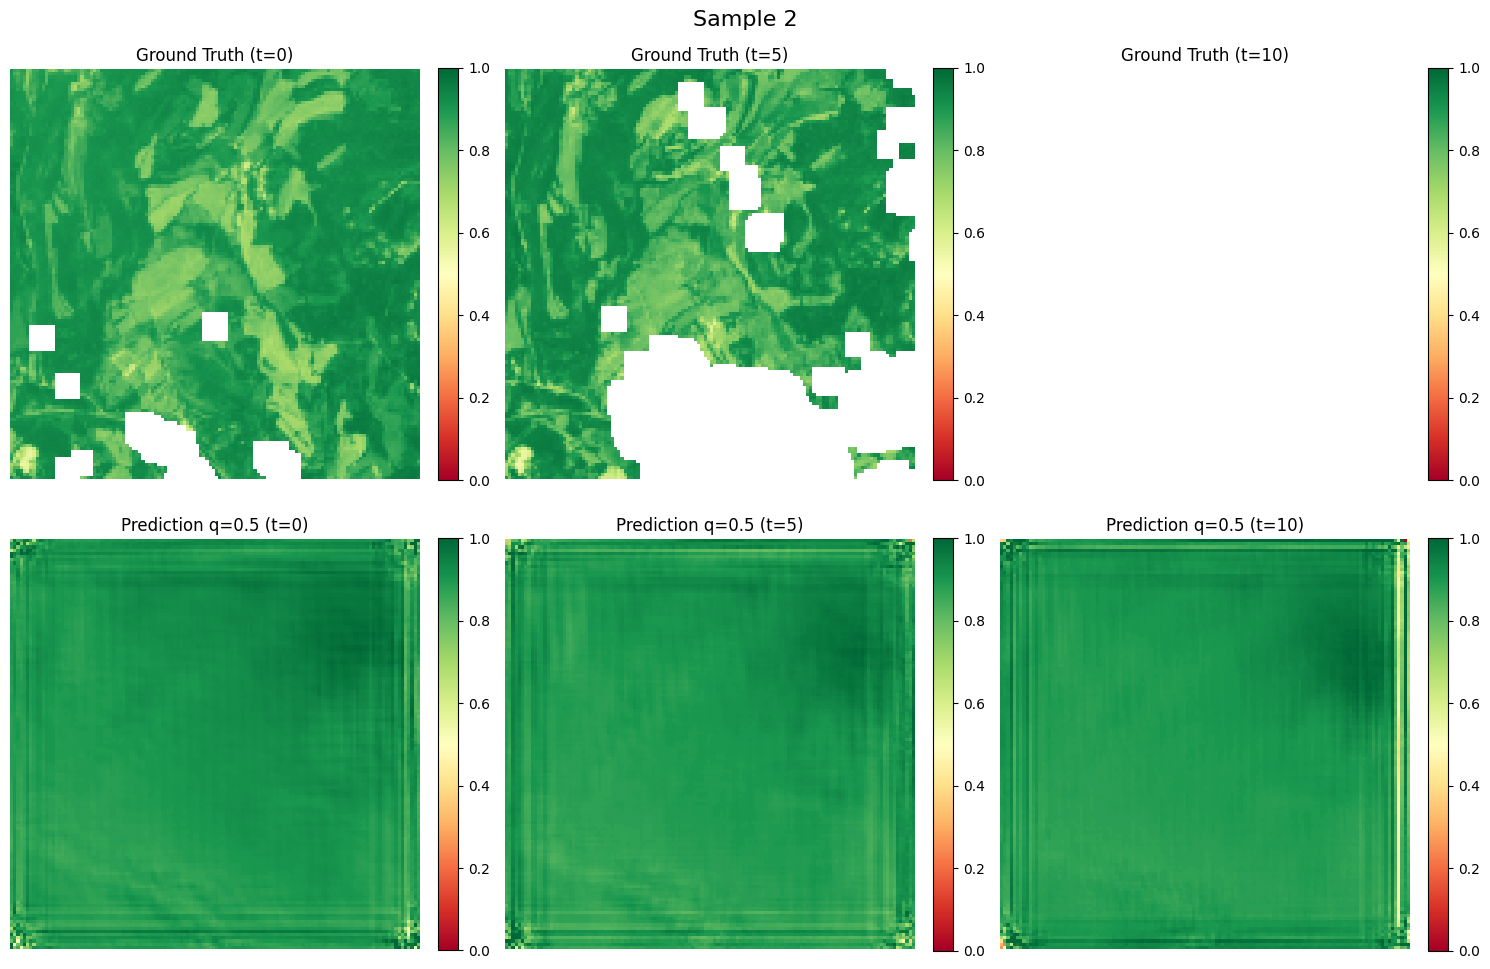

Sample 2 Metrics:
  MSE: 0.0057
  MAE: 0.0572


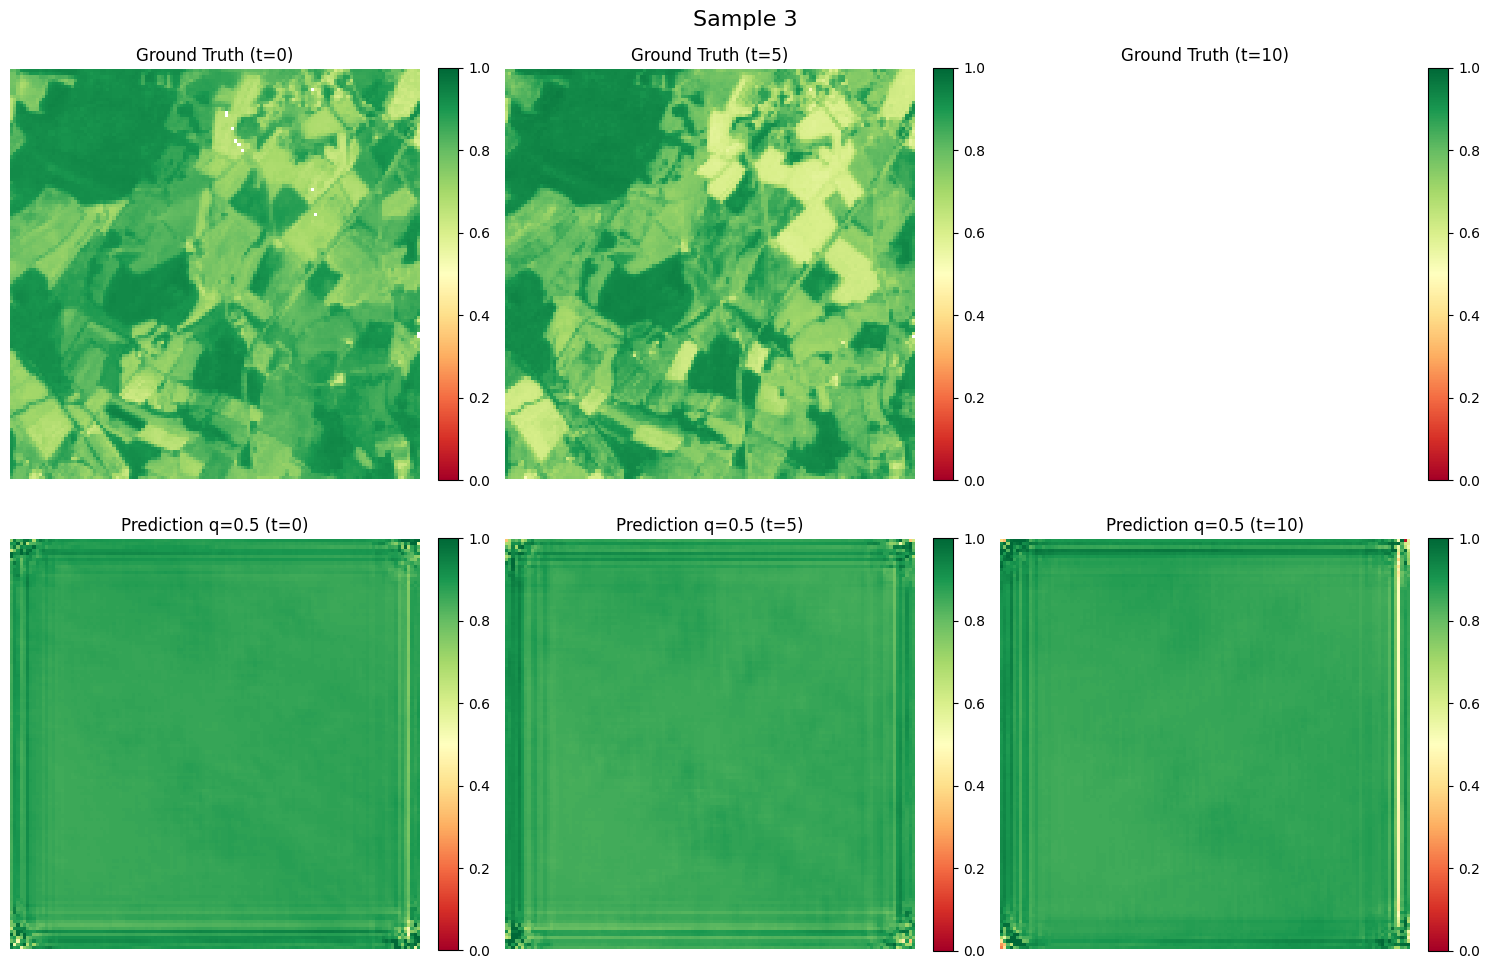

Sample 3 Metrics:
  MSE: 0.0114
  MAE: 0.0827


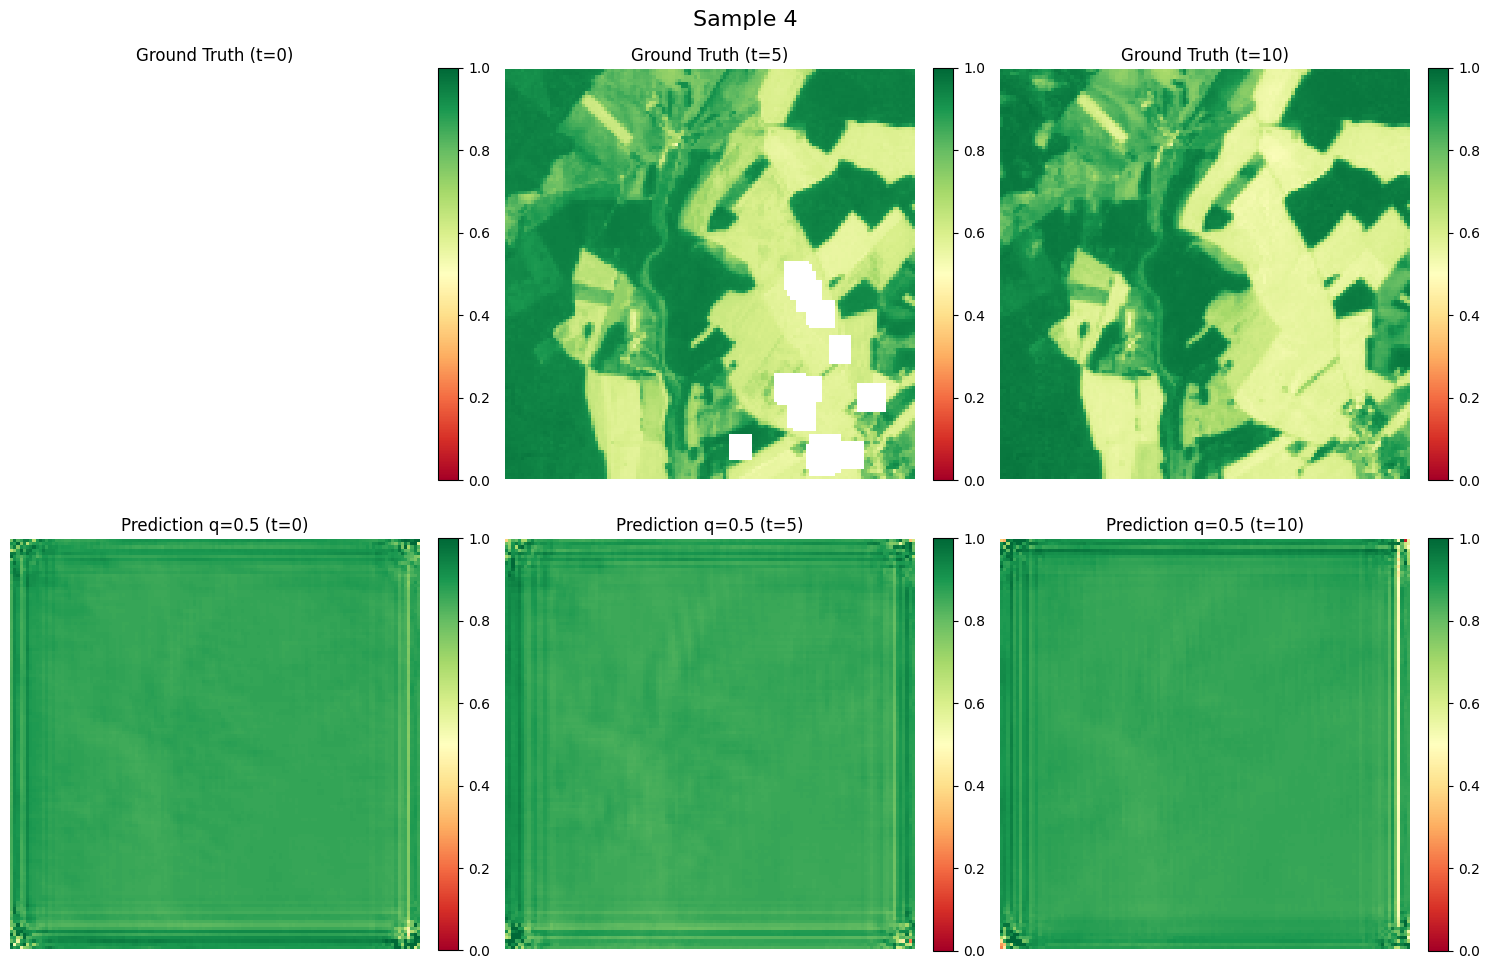

Sample 4 Metrics:
  MSE: 0.0284
  MAE: 0.1379


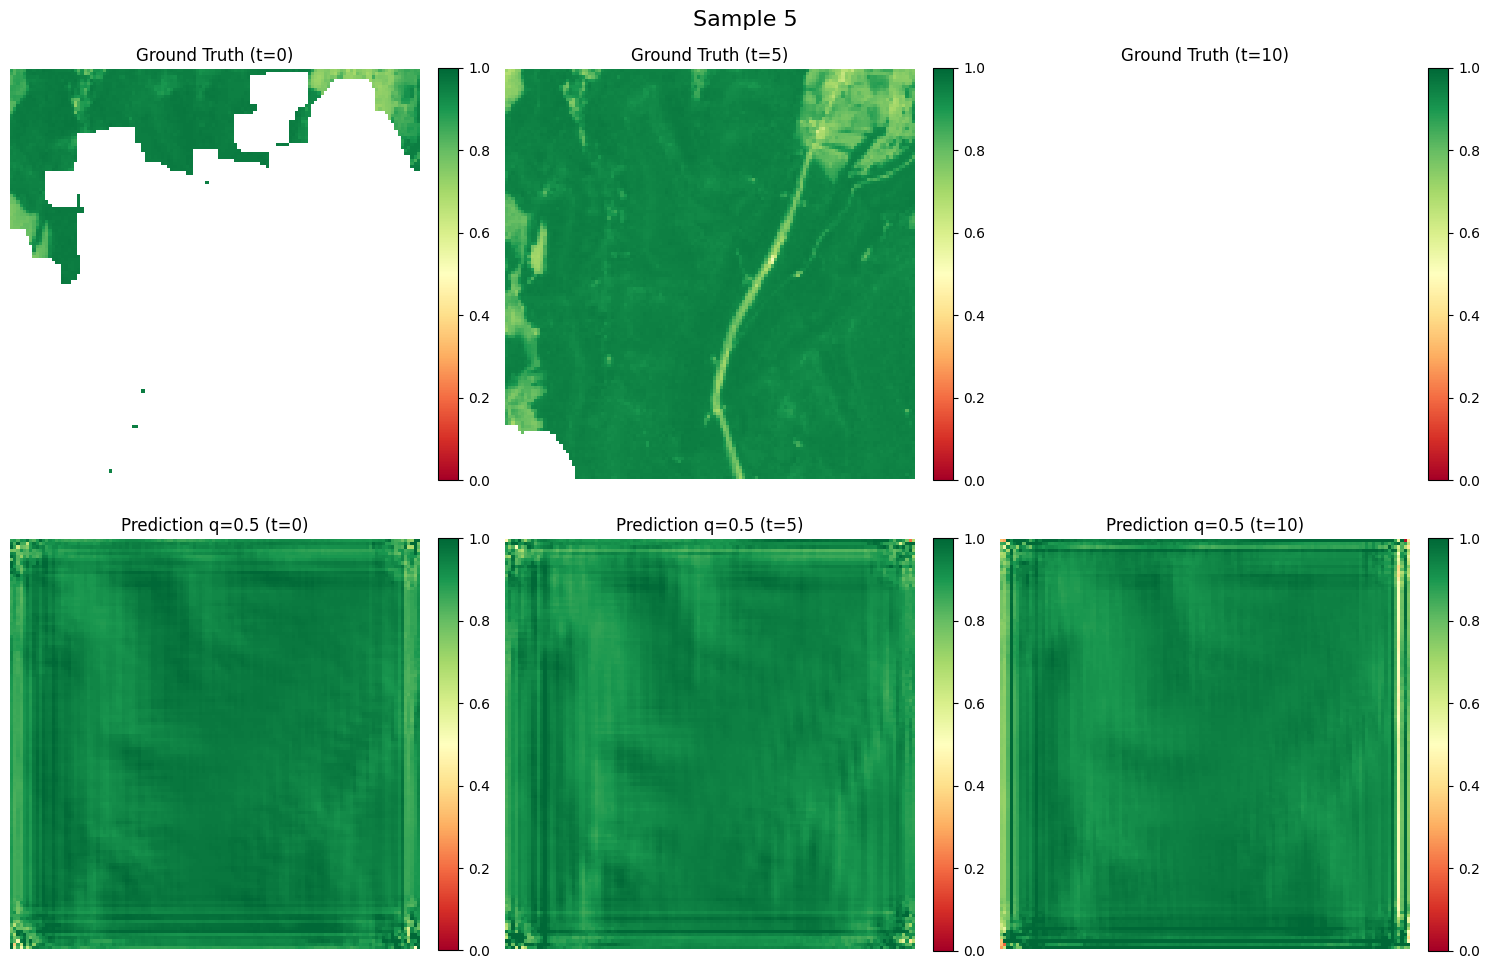

Sample 5 Metrics:
  MSE: 0.0027
  MAE: 0.0327


In [10]:
def plot_sample(x, y_true, y_pred, sample_idx):
    # y_true: (20, 128, 128)
    # y_pred: (n_quantile, 20, 128, 128) 
    
    # Extract median prediction (q=0.5, idx=1)
    pred_median = y_pred[1] # (20, 128, 128)
    
    # Select time steps to visualize (e.g., start, middle, end)
    time_steps = [0, 5, 10]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Sample {sample_idx+1}', fontsize=16)
    
    for i, t in enumerate(time_steps):
        # Ground Truth
        ax_gt = axes[0, i]
        im_gt = ax_gt.imshow(y_true[t], cmap='RdYlGn', vmin=0, vmax=1)
        ax_gt.set_title(f'Ground Truth (t={t})')
        ax_gt.axis('off')
        plt.colorbar(im_gt, ax=ax_gt, fraction=0.046, pad=0.04)
        
        # Prediction
        ax_pred = axes[1, i]
        im_pred = ax_pred.imshow(pred_median[t], cmap='RdYlGn', vmin=0, vmax=1)
        ax_pred.set_title(f'Prediction q=0.5 (t={t})')
        ax_pred.axis('off')
        plt.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate Metrics for this sample
    # Mask NaNs in y_true (if any)
    mask = ~np.isnan(y_true)
    
    mse = np.mean((y_true[mask] - pred_median[mask])**2)
    mae = np.mean(np.abs(y_true[mask] - pred_median[mask]))
    
    print(f"Sample {sample_idx+1} Metrics:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")

# Run prediction and plotting
for i, (x, y) in enumerate(samples):
    # Add batch dimension
    x_batch = {k: tf.expand_dims(v, 0) for k, v in x.items()}
    
    # Predict
    y_pred = model(x_batch)
    
    # Convert to numpy
    y_pred_np = y_pred[0, :, :, :, :, 0].numpy()    # Shape: (3, 20, 128, 128)   
    y_true_np = y[:, :, :, 0].numpy()             # Shape: (20, 128, 128)
    
    plot_sample(x, y_true_np, y_pred_np, i)